## Import all dependencies

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as ToTensor
import torchvision.transforms as Lambda
import torchvision.datasets as ImageFolder
import torch.utils.data as DataLoader
import torch.utils.data as Dataset
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torchsummary import summary
from PIL import Image

## Clear Cache

In [2]:
torch.cuda.empty_cache()

## Download Stanford dog images

In [3]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2024-02-13 12:23:14--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  18.1MB/s    in 45s     

2024-02-13 12:23:59 (16.8 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [4]:
!rm -r dataset
!mkdir dataset
!tar -xf images.tar -C ./dataset
!mv ./dataset/Images ./dataset/dogs
dog_list = os.listdir('dataset/dogs')
print(dog_list[:5],'...')
!wget https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt

rm: cannot remove 'dataset': No such file or directory
['n02109525-Saint_Bernard', 'n02098105-soft-coated_wheaten_terrier', 'n02090622-borzoi', 'n02086079-Pekinese', 'n02097130-giant_schnauzer'] ...
--2024-02-13 12:25:30--  https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31675 (31K) [text/plain]
Saving to: ‘synset_words.txt’

synset_words.txt    100%[===================>]  30.93K  --.-KB/s    in 0.003s  

2024-02-13 12:25:30 (11.1 MB/s) - ‘synset_words.txt’ saved [31675/31675]



## Setting

In [5]:
# Path Name
image_dir = "./dataset/dogs/"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu

# Hyperparameters (Set some contants...)
RANDOM_SEED = 0
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
NUM_EPOCHS_ft = 25
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)

# Fixed Parameters
N_CHANNELS = 3
NUMBER_CLASSES = 120

## Creating Custom Dataset
Note: Passing the modification on the datasets

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, image_transform = None, label_transform = None, train: bool = True):
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.train = train
        self.images, self.labels = self.creatdataset(file_path)
        # self.class_names = {}


    def creatdataset(self, file_path):
        list_images = []
        list_labels = []
        num_sample_train = 12000
        for index, subfolder in enumerate(os.listdir(image_dir)):
            dogname = subfolder[subfolder.index('-') + 1:]
            ID = subfolder.split('-')[0]
            # self.class_names[index] = dogname
            for image in os.listdir(os.path.join(file_path, subfolder)):
                if ((Image.open(os.path.join(file_path, subfolder, image)).getbands() == ("R", "G", "B")) and (image.endswith('.jpg'))):
                   list_images.append((os.path.join(file_path, subfolder, image)))
                   list_labels.append(index)

        random.seed(0)
        indexes_train = random.sample(range(len(list_images)), num_sample_train)

        if self.train:
           list_images = [list_images[i] for i in indexes_train]
           list_labels = [list_labels[i] for i in indexes_train]
        else:
            list_images = [list_images[i] for i in range(len(list_images)) if i not in indexes_train]
            list_labels = [list_labels[i] for i in range(len(list_labels)) if i not in indexes_train]

        return list_images, list_labels


    def __len__(self):
        return len(self.images)


    def __getitem__(self, index):
        image = Image.open(self.images[index])
        label = self.labels[index]

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

## Calculate mean and std values of train dataset

In [7]:
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = CustomDataset(image_dir, image_transform = transform, label_transform = None, train=True)
train_ldr = torch.utils.data.DataLoader(dataset = train_ds, batch_size = BATCH_SIZE, shuffle = True)

In [8]:
mean = torch.zeros(3)
std = torch.zeros(3)

for inputs, _labels in train_ldr:
    for i in range(N_CHANNELS):
        mean[i] += inputs[:, i, :, :].mean()
        std[i] += inputs[:, i, :, :].std()
mean.div_(len(train_ldr))
std.div_(len(train_ldr))

print('mean: ', mean, '\n', 'std: ', std)

mean:  tensor([0.4759, 0.4511, 0.3904]) 
 std:  tensor([0.2581, 0.2528, 0.2570])


## Passing the transforms to the train and test datasets
Note: Data augmentation and normalization for training dataset and just normalization for test dataset

In [9]:
train_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.005),
                                      transforms.Normalize(mean.tolist(), std.tolist())]) # train transform

test_transform = transforms.Compose([
    transforms.Resize((180, 180)), transforms.ToTensor(), transforms.Normalize(mean.tolist(), std.tolist())]) # test transform

label_transform = transforms.Lambda(lambda label: torch.zeros(NUMBER_CLASSES, dtype=torch.float).scatter_(0, torch.tensor(label), value=1)) # label transform

train_dataset = CustomDataset(image_dir, train_transform, label_transform, train=True)

test_dataset = CustomDataset(image_dir, test_transform, label_transform, train=False)

## Dataloaders
Note: Combines a dataset and a sampler, and provides an iterable over the given dataset.

In [10]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

## Training a model from scratch
### Creating an instance model

In [ ]:
scratch_model = models.efficientnet_b0().to(device)
scratch_model.classifier[1] = nn.Linear(in_features=1280, out_features=NUMBER_CLASSES, bias=True)
scratch_model.to(device)

## Setting the loss function and optimizer

In [12]:
optimizer = optim.Adam(params = scratch_model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## Visualizing the model
Note: Torchview provides visualization of models in the form of visual graphs.

In [ ]:
summary(scratch_model, (3, 224, 224))

## Training loop

In [ ]:
# Training loop
train_loss_list = []
test_loss_list = []
scratch_model.train()
for epoch in range(NUM_EPOCHS):
    losses = 0
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for images, labels in train_loader:
        # push images and labels to device to get CPU support
        images = images.to(device)
        labels = labels.to(device)
        predic_labels = scratch_model(images).to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        loss = criterion(predic_labels, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        losses += loss.item()

        epoch_accuracy += ((predic_labels.argmax(dim=1) == labels.argmax(dim=1)).float().mean())
    epoch_loss = losses / len(train_loader)

    # Test the model
    scratch_model.eval()
    with torch.no_grad():
      test_losses = 0
      epoch_test_accuracy = 0.0
      epoch_test_loss = 0.0

      for data,label in test_loader:
        data = data.to(device)
        label = label.to(device)
        predic_testlabel = scratch_model(data).to(device)
        test_loss = criterion(predic_testlabel, label)
        test_losses += test_loss.item()

        epoch_test_accuracy += ((predic_testlabel.argmax(dim=1) == label.argmax(dim=1)).float().mean())
    epoch_test_loss += test_losses/len(test_loader)
    ## loss data for Plot
    train_loss_list.append(epoch_loss)
    test_loss_list.append(epoch_test_loss)

    print('Epoch {}: , train accuracy: {}, train loss: {}, test_accuracy: {}, test_loss: {}'.format(epoch+1, epoch_accuracy / len(train_loader), epoch_loss, epoch_test_accuracy / len(test_loader), epoch_test_loss))


Epoch 1: , train accuracy: 0.01520944107323885, train loss: 4.758644583377432, test_accuracy: 0.02638888917863369, test_loss: 4.557369493555139
Epoch 2: , train accuracy: 0.02360372245311737, train loss: 4.612247740968745, test_accuracy: 0.024768518283963203, test_loss: 4.567222340901693
Epoch 3: , train accuracy: 0.03158244490623474, train loss: 4.485703052358424, test_accuracy: 0.03726851940155029, test_loss: 4.425024126194142
Epoch 4: , train accuracy: 0.041888296604156494, train loss: 4.341973360548628, test_accuracy: 0.046296294778585434, test_loss: 4.297106875313653
Epoch 5: , train accuracy: 0.05435505136847496, train loss: 4.197729052381312, test_accuracy: 0.04606481269001961, test_loss: 4.32726048540186
Epoch 6: , train accuracy: 0.06432845443487167, train loss: 4.073495346180936, test_accuracy: 0.06122685223817825, test_loss: 4.147343836890327
Epoch 7: , train accuracy: 0.07205784320831299, train loss: 3.987050561194724, test_accuracy: 0.06666666269302368, test_loss: 4.040315

## Plot Losses of train and test data

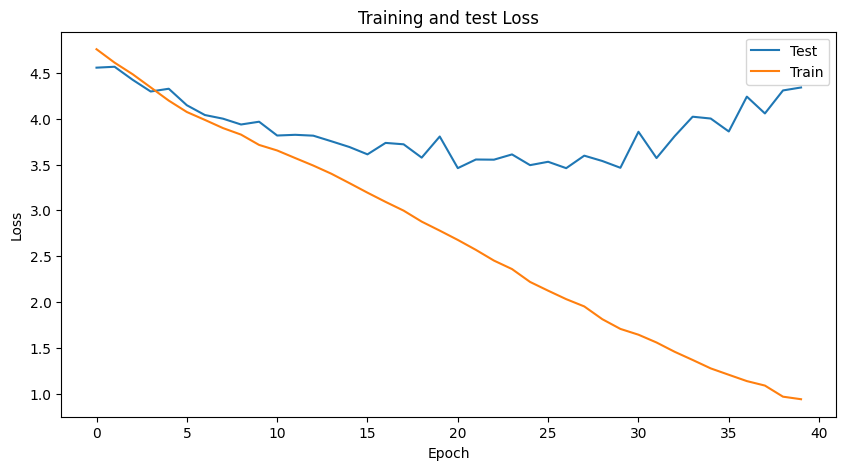

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and test Loss")
plt.plot(test_loss_list, label="Test")
plt.plot(train_loss_list, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Transfer learning from pre-trained weights

In [ ]:
pip install efficientnet_pytorch

## Import dependency for EfficientNet model

In [14]:
from efficientnet_pytorch import EfficientNet

## Declare model
Note: The first step to transfer learning is to freeze all layers and later unfreeze the desired blocks (Only desired blocks will train).

In [15]:
#using efficientnet model based transfer learning
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.efficientnet =  EfficientNet.from_pretrained('efficientnet-b0')
        # freeze all layers
        for p in self.efficientnet.parameters():
          p.requires_grad = False
        # Unfreeze last layer
        for param in self.efficientnet._fc.parameters():
          param.requires_grad = True
        for param in self.efficientnet._dropout.parameters():
          param.requires_grad = True

        self.efficientnet._dropout = nn.Sequential(nn.BatchNorm1d(1280), nn.Dropout(p=0.2, inplace=True))
        self.efficientnet._fc = nn.Linear(in_features=1280, out_features=120, bias=True)
        self.efficientnet._swish = nn.Identity()
    def forward(self, x):
        x = self.efficientnet(x)
        return x

## Creating an instance model

In [16]:
efficientnet_model = Classifier().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 95.3MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
print(efficientnet_model)

## Setting the loss function and optimizer

In [17]:
_optimizer = optim.Adam(params = efficientnet_model.parameters(), lr = LEARNING_RATE)
_criterion = nn.CrossEntropyLoss()

## Training Loop

In [ ]:
# Training loop
train_loss_list_ft = []
test_loss_list_ft = []
NUM_EPOCHS_ft = 25
efficientnet_model.train()
for epoch in range(NUM_EPOCHS_ft):
    losses = 0
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for images, labels in train_loader:
        # push images and labels to device to get CPU support
        images = images.to(device)
        labels = labels.to(device)
        predic_labels = efficientnet_model(images).to(device)
        # Zero the gradients
        _optimizer.zero_grad()
        # Forward pass
        loss = _criterion(predic_labels, labels)
        # Backward pass and optimization
        loss.backward()
        _optimizer.step()
        losses += loss.item()

        epoch_accuracy += ((predic_labels.argmax(dim=1) == labels.argmax(dim=1)).float().mean())
    epoch_loss = losses / len(train_loader)

    # Test the model
    efficientnet_model.eval()
    with torch.no_grad():
      test_losses = 0
      epoch_test_accuracy = 0.0
      epoch_test_loss = 0.0

      for data,label in test_loader:
        data = data.to(device)
        label = label.to(device)
        predic_testlabel = efficientnet_model(data).to(device)
        test_loss = _criterion(predic_testlabel, label)
        test_losses += test_loss.item()

        epoch_test_accuracy += ((predic_testlabel.argmax(dim=1) == label.argmax(dim=1)).float().mean())
    epoch_test_loss += test_losses/len(test_loader)
    ## loss data for Plot
    train_loss_list_ft.append(epoch_loss)
    test_loss_list_ft.append(epoch_test_loss)

    print('Epoch {}: , train accuracy: {}, train loss: {}, test_accuracy: {}, test_loss: {}'.format(epoch+1, epoch_accuracy / len(train_loader), epoch_loss, epoch_test_accuracy / len(test_loader), epoch_test_loss))


Epoch 1: , train accuracy: 0.3967752456665039, train loss: 2.492424502651742, test_accuracy: 0.5819058418273926, test_loss: 1.516169810515863
Epoch 2: , train accuracy: 0.708776593208313, train loss: 1.0270256197198908, test_accuracy: 0.5989969372749329, test_loss: 1.4829787810643513
Epoch 3: , train accuracy: 0.7633809447288513, train loss: 0.8108951241729108, test_accuracy: 0.6009644865989685, test_loss: 1.5264102013022811
Epoch 4: , train accuracy: 0.7928025126457214, train loss: 0.7029359077519559, test_accuracy: 0.598881185054779, test_loss: 1.580191883334407
Epoch 5: , train accuracy: 0.8171542286872864, train loss: 0.615190705165584, test_accuracy: 0.597993791103363, test_loss: 1.6458593236075507
Epoch 6: , train accuracy: 0.8296209573745728, train loss: 0.5596915298002831, test_accuracy: 0.6018132567405701, test_loss: 1.7005670777073614
Epoch 7: , train accuracy: 0.842004656791687, train loss: 0.5101690503193977, test_accuracy: 0.5886573791503906, test_loss: 1.8000531249576144


## Plot Loss of train and test data
Note: The test accuracy and loss will usually be better than training accuracy. This is because the regularization is strong, which only suppresses training-time metrics.


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and test Loss")
plt.plot(test_loss_list_ft, label="Test")
plt.plot(train_loss_list_ft, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()